In [1]:
# Text Classification / tc-nltk-lstm-rnn-9.ipynb
# Gourav Siddhad
# 26-Mar-2019

In [2]:
print('Importing Libraries', end='')

import pandas as pd
import numpy as np
from numpy.random import seed
import re
import os
import pandas as pd
import time

import matplotlib.pyplot as plt

import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.corpus import reuters, stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from keras.models import Model, model_from_json, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

from scipy import interp
from itertools import cycle

print(' - Done')

Importing Libraries

Using TensorFlow backend.


 - Done


In [3]:
documents = reuters.fileids()
print('Total Documents -', len(documents))

print('Extracting (Id, Docs and Labels)', end='')
train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))

train_docs = [reuters.raw(doc_id) for doc_id in train_docs_id]
test_docs = [reuters.raw(doc_id) for doc_id in test_docs_id]
all_docs = train_docs
all_docs += test_docs

train_labels = [reuters.categories(doc_id) for doc_id in train_docs_id]
test_labels  = [reuters.categories(doc_id) for doc_id in test_docs_id]
all_labels = train_labels
all_labels += test_labels
print(' - Done')

del train_docs
del test_docs
del train_labels
del test_labels

print('Documents - ', len(all_docs))
print('Labels  - ', len(all_labels))

# List of categories
categories = reuters.categories()
print('Categories - ', len(categories))

print('Caching Stop Words', end='')
cachedStopWords = stopwords.words("english")
print(' - Done')

Total Documents - 10788
Extracting (Id, Docs and Labels) - Done
Documents -  10788
Labels  -  10788
Categories -  90
Caching Stop Words - Done


In [4]:
print('Sorting Train:Test Docs', end='')
X_train, X_test, y_train, y_test = train_test_split(all_docs, all_labels, test_size=0.2, random_state=42)
print(' - Done')

maxwords = 6000

print('Tokenizing', end='')
tk = Tokenizer(num_words=maxwords)
tk.fit_on_texts(X_train)
tk.fit_on_texts(X_test)
index_list_train = tk.texts_to_sequences(X_train)
index_list_test = tk.texts_to_sequences(X_test)
print(' - Done')

Sorting Train:Test Docs - Done
Tokenizing - Done


In [5]:
# max of index_list_train
# max of index_list_test

maxlen = 200

for i in index_list_train:
    if len(i)>maxlen:
        maxlen = len(i)
print(maxlen)

for i in index_list_test:
    if len(i)>maxlen:
        maxlen = len(i)
print(maxlen)

2306
2306


In [6]:
maxlen = 1600

print('Padding Sequences', end='')
x_train = sequence.pad_sequences(index_list_train, maxlen=maxlen)
x_test = sequence.pad_sequences(index_list_test, maxlen=maxlen)
print(' - Done')

print('Binarizing MultiLabels', end='')
lb = MultiLabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print(' - Done')

Padding Sequences - Done
Binarizing MultiLabels - Done


In [7]:
del all_docs
del all_labels

In [8]:
def RNN():
    inputs = Input(name='inputs', shape=[maxlen])
    layer = Embedding(maxwords, 512, input_length=maxlen)(inputs)
    layer = LSTM(256)(layer)
    layer = Dense(128, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(rate = 0.05)(layer) # rate = 1-keep_prob, keep_prob=0.5
    layer = Dense(len(categories), name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [9]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1600)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1600, 512)         3072000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
FC1 (Dense)                  (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 90)                11610     
__________

In [10]:
checkpoint = ModelCheckpoint('model-lstm-9-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', 
                             verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_split=0.3, shuffle=True, callbacks=[checkpoint])

Train on 6041 samples, validate on 2589 samples
Epoch 1/100
6041/6041 [==============================] - 178s 30ms/step - loss: 4.3738 - acc: 0.3478 - val_loss: 3.5294 - val_acc: 0.3770

Epoch 00001: val_loss improved from inf to 3.52940, saving model to model-lstm-8-001-0.347790-0.376980.h5
Epoch 2/100
6041/6041 [==============================] - 176s 29ms/step - loss: 3.2525 - acc: 0.4714 - val_loss: 3.1274 - val_acc: 0.5091

Epoch 00002: val_loss improved from 3.52940 to 3.12735, saving model to model-lstm-8-002-0.471445-0.509077.h5
Epoch 3/100
6041/6041 [==============================] - 179s 30ms/step - loss: 2.8632 - acc: 0.5347 - val_loss: 2.8092 - val_acc: 0.5716

Epoch 00003: val_loss improved from 3.12735 to 2.80922, saving model to model-lstm-8-003-0.534680-0.571649.h5
Epoch 4/100
6041/6041 [==============================] - 174s 29ms/step - loss: 2.4872 - acc: 0.6014 - val_loss: 2.4915 - val_acc: 0.6257

Epoch 00004: val_loss improved from 2.80922 to 2.49153, saving model t

6041/6041 [==============================] - 194s 32ms/step - loss: 0.4169 - acc: 0.9194 - val_loss: 2.8539 - val_acc: 0.7439

Epoch 00084: val_loss did not improve from 2.08619
Epoch 85/100
6041/6041 [==============================] - 198s 33ms/step - loss: 0.4149 - acc: 0.9181 - val_loss: 2.8244 - val_acc: 0.7416

Epoch 00085: val_loss did not improve from 2.08619
Epoch 86/100
6041/6041 [==============================] - 197s 33ms/step - loss: 0.4129 - acc: 0.9157 - val_loss: 2.8963 - val_acc: 0.7439

Epoch 00086: val_loss did not improve from 2.08619
Epoch 87/100
6041/6041 [==============================] - 195s 32ms/step - loss: 0.4078 - acc: 0.9152 - val_loss: 2.8614 - val_acc: 0.7513

Epoch 00087: val_loss did not improve from 2.08619
Epoch 88/100
6041/6041 [==============================] - 190s 31ms/step - loss: 0.4086 - acc: 0.9192 - val_loss: 2.8321 - val_acc: 0.7462

Epoch 00088: val_loss did not improve from 2.08619
Epoch 89/100
6041/6041 [==============================] - 

In [12]:
# Save Complete Model
model.save('tc-nltk-lstm-rnn-9.h5')

# Save Model Configuration to JSON
model_json = model.to_json()
with open('tc-nltk-lstm-rnn-9.json', 'w') as json_file:
    json_file.write(model_json)

# Load a Saved Model
# model = load_model('tc-nltk-lstm-rnn.h5')

In [17]:
# Load Model Configuration from JSON
json_file = open('tc-nltk-lstm-rnn-9.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('model-lstm-9-010-0.764277-0.708768.h5') # Change before running
loaded_model.save('tc-nltk-lstm-rnn-9-weights.hdf5')
loaded_model=load_model('tc-nltk-lstm-rnn-9-weights.hdf5')

C:\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [18]:
accr = model.evaluate(x_test, y_test, batch_size=256)
print()
print('Loss: {:0.3f}\tAccuracy: {:0.3f}'.format(accr[0], accr[1]))

2158/2158 [==============================] - 11s 5ms/step

Loss: 2.889	Accuracy: 0.735


In [15]:
# plot_model(model, to_file='tc-nltk-lstm-4-model.png')

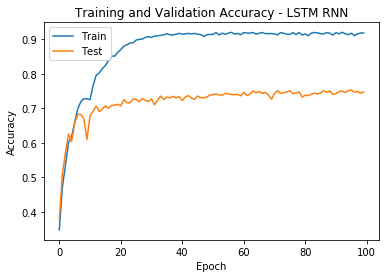

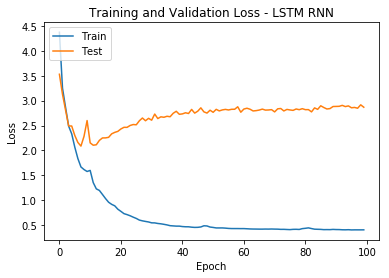

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and Validation Accuracy - LSTM RNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('tc-nltk-lstm-rnn-9-acc.png', dpi=300, pad_inches=0.1)
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss - LSTM RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('tc-nltk-lstm-rnn-9-loss.png', dpi=300, pad_inches=0.1)
plt.show()